### Setup

apt install requirements

In [1]:
# !apt-get install -y \
#     libgl1-mesa-dev \
#     libgl1-mesa-glx \
#     libglew-dev \
#     libosmesa6-dev \
#     software-properties-common

# !apt-get install -y patchelf

Clone repo and install dependencies

In [2]:
# %cd /content

# ## TODO: use when repo is public
# # !git clone https://github.com/jannerm/diffuser.git
# ## backup for private repo
# !curl -L -o diffuser.zip https://www.dropbox.com/s/fe1scd8m2jf7zvj/diffuser.tar?dl=1
# !tar -xf diffuser.zip
# ## /TODO

# %cd diffuser
# %pip install -f https://download.pytorch.org/whl/torch_stable.html \
#                 typed-argument-parser \
#                 scikit-image==0.17.2 \
#                 scikit-video==1.1.11 \
#                 gitpython \
#                 einops \
#                 pillow \
#                 free-mujoco-py \
#                 gym \
#                 git+https://github.com/JannerM/d4rl.git@0e84a4d29db3ae501043215ce1d91843929f1949 \
#                 git+https://github.com/aravindr93/mjrl

# %pip install -e .

In [3]:
import os
import json
import numpy as np
from os.path import join
import pdb

from diffuser.guides.policies import Policy
import diffuser.datasets as datasets
import diffuser.utils as utils

/opt/conda/envs/diffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Nov 28 2023 23:51:11


In [4]:
os.chdir('/root/diffuser')

Arguments

In [5]:
savepath = 'logs/maze2d-large-v1/rollouts'
os.makedirs(savepath, exist_ok=True)
vis_freq = 10
batch_size = 1

Loading

In [9]:
dataset = 'maze2d-large-v1'

env = datasets.load_environment(dataset)

diffusion_experiment = utils.load_diffusion('logs_2', dataset, 'diffusion/H384_T256', epoch='latest')

diffusion = diffusion_experiment.ema
dataset = diffusion_experiment.dataset
renderer = diffusion_experiment.renderer

policy = Policy(diffusion, dataset.normalizer)

[ utils/serialization ] Loaded config from logs_2/maze2d-large-v1/diffusion/H384_T256/dataset_config.pkl

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-large-v1
    horizon: 384
    max_path_length: 40000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/serialization ] Loaded config from logs_2/maze2d-large-v1/diffusion/H384_T256/render_config.pkl

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-large-v1

[ utils/serialization ] Loaded config from logs_2/maze2d-large-v1/diffusion/H384_T256/model_config.pkl

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 384
    transition_dim: 6

[ utils/serialization ] Loaded config from logs_2/maze2d-large-v1/diffusion/H384_T256/diffusion_config.pkl

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianDiffusion'>
  

load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]


[ utils/preprocessing ] Segmented maze2d-large-v1 | 1061 paths | min length: 67 | max length: 30470
[ datasets/buffer ] Finalized replay buffer | 1062 episodes
[ datasets/buffer ] Fields:
    actions: (1062, 40000, 2)
    infos/goal: (1062, 40000, 2)
    infos/qpos: (1062, 40000, 2)
    infos/qvel: (1062, 40000, 2)
    observations: (1062, 40000, 4)
    rewards: (1062, 40000, 1)
    terminals: (1062, 40000, 1)
    timeouts: (1062, 40000, 1)
    next_observations: (1062, 40000, 4)
    normed_observations: (1062, 40000, 4)
    normed_actions: (1062, 40000, 2)
[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]

[ utils/serialization ] Loading model epoch: 1960000



Main Loop

In [27]:
observation = env.reset()
isconditioned = True

if isconditioned:
    print('Resetting target')
    env.set_target()

## set conditioning xy position to be the goal
target = env._target
cond = {
    diffusion.horizon - 1: np.array([*target, 0, 0]),
}

## observations for rendering
rollout = [observation.copy()]

total_reward = 0

Resetting target



                                                                                                    
1 / 256 [                                                            ]   0% | 97.1 Hz
t : 255
                                                                                                    
                                                                                                    
2 / 256 [                                                            ]   0% | 108.1 Hz
t : 254
                                                                                                    
                                                                                                    
3 / 256 [                                                            ]   1% | 112.8 Hz
t : 253
                                                                                                    
                                                                                                    
4 / 256 

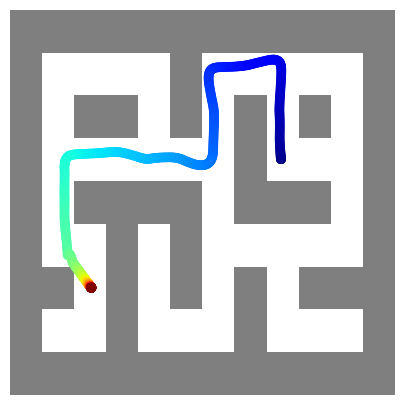

In [28]:
for t in range(env.max_episode_steps):

    state = env.state_vector().copy()

    ## can replan if desired, but the open-loop plans are good enough for maze2d
    ## that we really only need to plan once
    if t == 0:
        cond[0] = observation

        action, samples = policy(cond, batch_size=batch_size)
        actions = samples.actions[0]
        sequence = samples.observations[0]
    # pdb.set_trace()

    # ####
    if t < len(sequence) - 1:
        next_waypoint = sequence[t+1]
    else:
        next_waypoint = sequence[-1].copy()
        next_waypoint[2:] = 0
        # pdb.set_trace()

    ## can use actions or define a simple controller based on state predictions
    action = next_waypoint[:2] - state[:2] + (next_waypoint[2:] - state[2:])
    # pdb.set_trace()
    ####

    # else:
    #     actions = actions[1:]
    #     if len(actions) > 1:
    #         action = actions[0]
    #     else:
    #         # action = np.zeros(2)
    #         action = -state[2:]
    #         pdb.set_trace()



    next_observation, reward, terminal, _ = env.step(action)
    total_reward += reward
    score = env.get_normalized_score(total_reward)
    print(
        f't: {t} | r: {reward:.2f} |  R: {total_reward:.2f} | score: {score:.4f} | ref_max_score: {env.ref_max_score} | ref_min_score: {env.ref_min_score}'
        f'{action}'
    )

    xy = next_observation[:2]
    goal = env.unwrapped._target
    print(f'maze | pos: {xy} | goal: {goal}')

    ## update rollout observations
    rollout.append(next_observation.copy())

    # logger.log(score=score, step=t)

    if t % vis_freq == 0 or terminal:
        fullpath = join(savepath, f'{t}.png')

        if t == 0: renderer.composite(fullpath, samples.observations, ncol=1)



        ## save rollout thus far
        renderer.composite(join(savepath, 'rollout.png'), np.array(rollout)[None], ncol=1)



    if terminal:
        break

    observation = next_observation

In [29]:
json_path = join(savepath, 'rollout.json')
json_data = {'score': score, 'step': t, 'return': total_reward, 'term': terminal,
    'epoch_diffusion': diffusion_experiment.epoch}
json.dump(json_data, open(json_path, 'w'), indent=2, sort_keys=True)

In [30]:
json_data

{'score': 1.3367503460660706,
 'step': 799,
 'return': 364.0,
 'term': False,
 'epoch_diffusion': 1960000}

In [31]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99


In [26]:
json_data

{'score': 1.6173444573309887,
 'step': 799,
 'return': 439.0,
 'term': False,
 'epoch_diffusion': 1960000}

In [25]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99


In [20]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99
